In [14]:
import os
import glob
import numpy as np
import pandas as pd


In [15]:

# ============================================================
# 設定（ここだけ自分の環境に合わせて変える）
# ============================================================
base_dir = r".\\data\\test_3_SKAB"  # ← この下に data/ がある想定
data_dir = os.path.join(base_dir, "data")

normal_csv = os.path.join(data_dir, "anomaly-free", "anomaly-free.csv")
other_dir  = os.path.join(data_dir, "other")

# 参照（正常）として使う点数、テストで「最初に流す正常点数」
# ※ 長すぎると計算が重くなるので、まずはこのくらいから推奨
N_REF = 6000
N_TEST_NORMAL_PREFIX = 3000

# 出力ファイル
out_npz = os.path.join(base_dir, "mmd_dataset_from_anomalyfree_other.npz")



In [16]:

# ============================================================
# 1) CSV読み込み（壊れにくい）
# ============================================================
def read_csv_robust(path):
    """
    CSV（;区切り）を読む。
    """
    return pd.read_csv(path, sep=";")


def list_csvs(dir_path):
    files = sorted(glob.glob(os.path.join(dir_path, "*.csv")))
    if len(files) == 0:
        raise FileNotFoundError(f"CSVが見つかりません: {dir_path}")
    return files


# ============================================================
# 2) 「使う列」を決める（全ファイルで共通の数値列）
# ============================================================
def numeric_common_columns(dfs, drop_like=("time", "timestamp", "date")):
    """
    複数DataFrameに共通して存在する「数値列」だけを返す。
    さらに time/timestamp/date っぽい列名は落とす（必要なら後で外す条件を変える）。
    """
    num_sets = []
    for df in dfs:
        num_cols = df.select_dtypes(include=[np.number]).columns
        num_sets.append(set(num_cols))

    common = set.intersection(*num_sets)
    common = [c for c in sorted(common) if not any(k in c.lower() for k in drop_like)]
    if len(common) == 0:
        raise ValueError(
            "共通の数値列が0です。"
            "CSVの列名がファイルごとに違う/数値に読めていない可能性があります。"
        )
    return common


def to_array(df, feature_cols):
    """
    指定列を (N, D) の float32 配列にする。
    NaN/inf は線形補間→残りは前後埋め→それでも残るなら0埋め。
    """
    x = df[feature_cols].copy()
    x = x.replace([np.inf, -np.inf], np.nan)

    # 時系列だと欠損が混じりやすいので、補間→埋め
    x = x.interpolate(limit_direction="both")
    x = x.fillna(method="ffill").fillna(method="bfill").fillna(0.0)

    return x.to_numpy(dtype=np.float32)



In [17]:

# ============================================================
# 3) 正常/異常データをロードして整形
# ============================================================
# 正常（1ファイル）
df_normal = read_csv_robust(normal_csv)

# 異常（other配下の複数ファイル）
other_files = list_csvs(other_dir)
dfs_other = [read_csv_robust(p) for p in other_files]

# 実行するかどうか選択
# ============================================================
#「anomaly-free の数値列（時間列を除く）を基準に採用」し、other 側にその列が揃っていないファイルは除外する
# anomaly-free を基準に列を決める（例）
num_cols = df_normal.select_dtypes(include=[np.number]).columns
feature_cols = [c for c in num_cols if "time" not in c.lower()]
# other 側で列が揃っているファイルだけ残す
ok_files = []
dfs_other_ok = []
for p, df in zip(other_files, dfs_other):
    if all(c in df.columns for c in feature_cols):
        ok_files.append(p)
        dfs_other_ok.append(df)

print("other files:", len(other_files), "->", len(ok_files), " (列が揃っているものだけ採用)")
other_files = ok_files
dfs_other = dfs_other_ok
# ===========================================================


# 全体で共通の数値列を採用（特徴量次元 D）
feature_cols = numeric_common_columns([df_normal] + dfs_other)

# 配列化
X_normal_all = to_array(df_normal, feature_cols)  # (Nn, D)
X_other_all_list = [to_array(df, feature_cols) for df in dfs_other]
X_other_all = np.vstack(X_other_all_list)         # (Ne, D)

print("==== 読み込み結果 ====")
print("normal:", X_normal_all.shape, "from", normal_csv)
print("other :", X_other_all.shape, "from", len(other_files), "files")
print("features D =", len(feature_cols))
print("feature_cols =", feature_cols)

other files: 14 -> 14  (列が揃っているものだけ採用)
==== 読み込み結果 ====
normal: (9405, 8) from .\\data\\test_3_SKAB\data\anomaly-free\anomaly-free.csv
other : (14929, 8) from 14 files
features D = 8
feature_cols = ['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure', 'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS']


C:\Users\tsenz\AppData\Local\Temp\ipykernel_13616\705680943.py:51: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x = x.fillna(method="ffill").fillna(method="bfill").fillna(0.0)
C:\Users\tsenz\AppData\Local\Temp\ipykernel_13616\705680943.py:51: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x = x.fillna(method="ffill").fillna(method="bfill").fillna(0.0)
C:\Users\tsenz\AppData\Local\Temp\ipykernel_13616\705680943.py:51: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x = x.fillna(method="ffill").fillna(method="bfill").fillna(0.0)
C:\Users\tsenz\AppData\Local\Temp\ipykernel_13616\705680943.py:51: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill()

X_all shape = (24334, 8)
y_all shape = (24334,)
normal rows = 9405 other rows = 14929


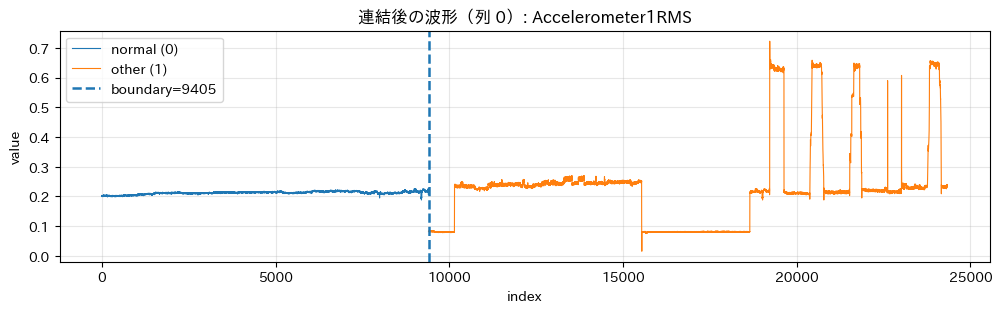

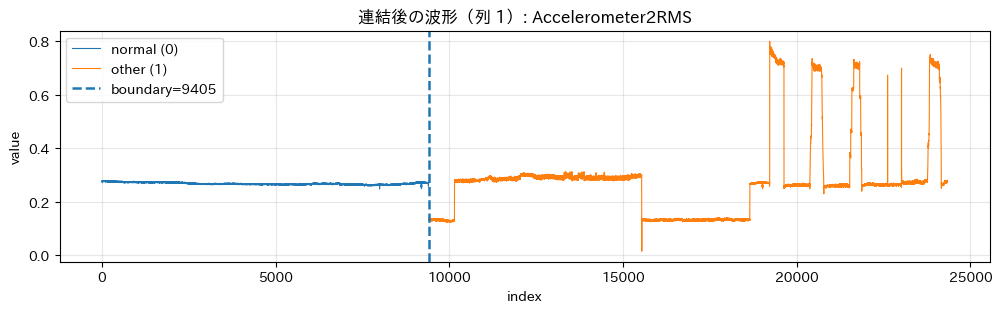

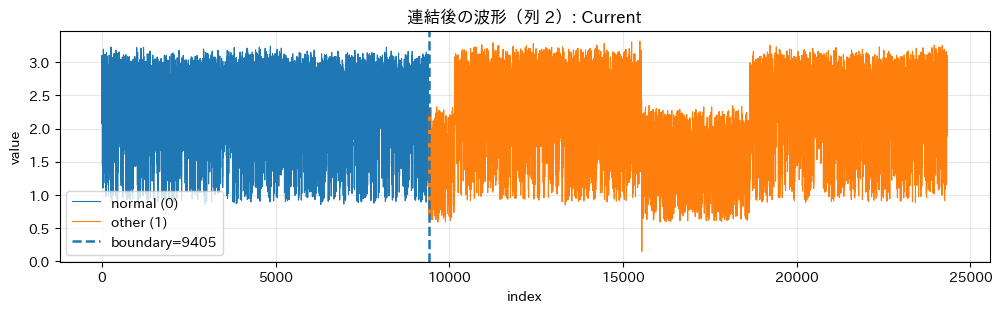

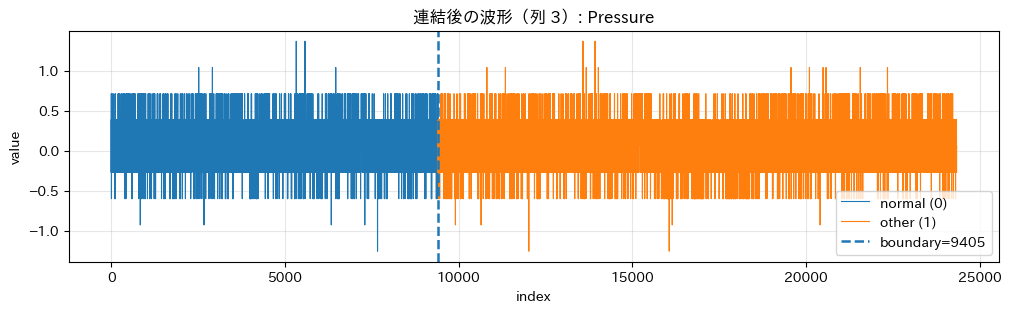

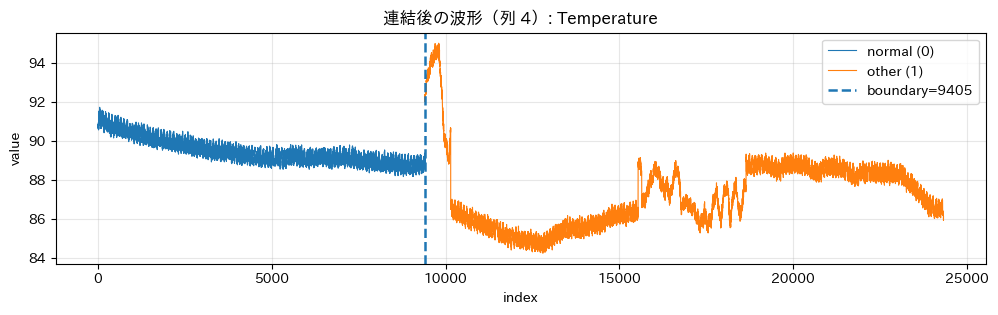

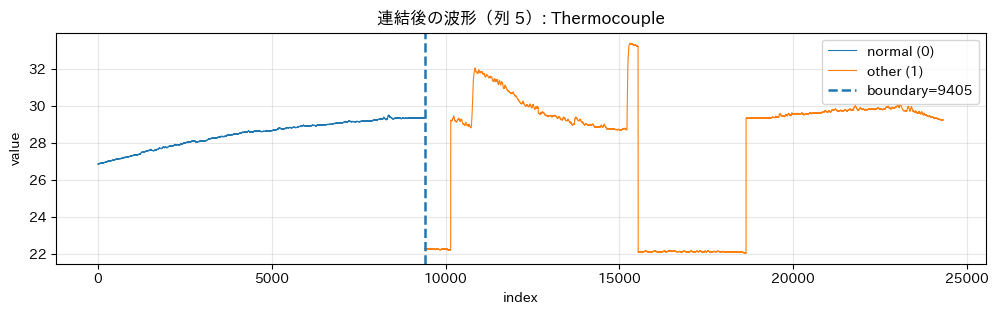

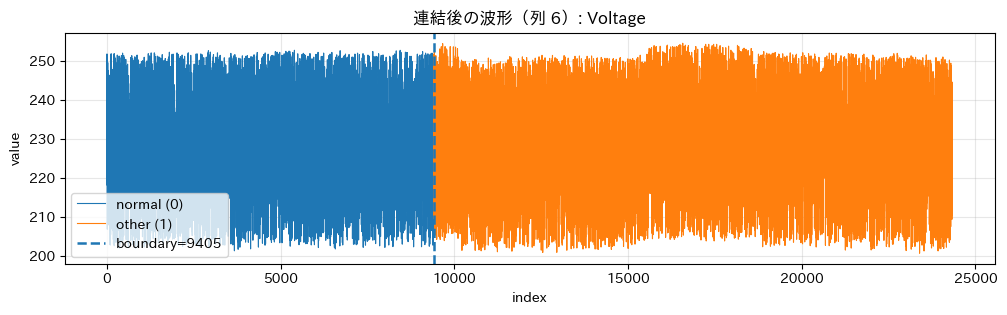

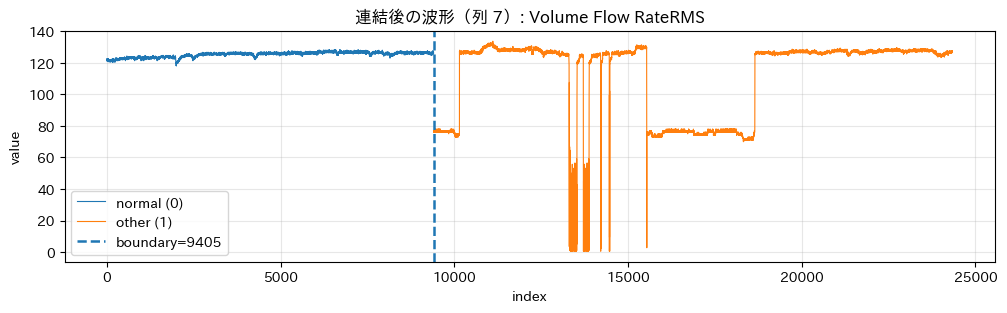

In [18]:
import numpy as np

# 前提:
#  X_normal_all: (Nn, D)
#  X_other_all : (No, D)

# 1) 1つに結合（縦方向に連結）
X_all = np.vstack([X_normal_all, X_other_all]).astype(np.float32)

# 2) ラベルも同時に作る（0=normal, 1=other）
y_all = np.concatenate([
    np.zeros(X_normal_all.shape[0], dtype=np.int32),
    np.ones(X_other_all.shape[0], dtype=np.int32)
])

print("X_all shape =", X_all.shape)
print("y_all shape =", y_all.shape)
print("normal rows =", (y_all == 0).sum(), "other rows =", (y_all == 1).sum())

import numpy as np
import matplotlib.pyplot as plt

# 前提:
#   X_all : (N, D)  連結後の配列
#   y_all : (N,)    0=normal, 1=other（任意。無くても動く）
#   feature_cols : 列名（任意）
#
# 目的:
#   列ごとに波形をプロット（正常区間と異常区間を色分け）
#   連結境界（normal→other）にも縦線を引く

N, D = X_all.shape
t = np.arange(N)

# 列名（なければ col0,col1,...）
if "feature_cols" in globals() and feature_cols is not None and len(feature_cols) == D:
    names = list(feature_cols)
else:
    names = [f"col{j}" for j in range(D)]

# 正常→異常の境界（y_all があれば推定、なければ normal部分行数を自分で入れる）
if "y_all" in globals():
    # 0→1 に変わる最初の場所
    ch = np.where(np.diff(y_all.astype(int)) != 0)[0]
    boundary = int(ch[0] + 1) if len(ch) > 0 else None
else:
    boundary = None  # 例: boundary = X_normal_all.shape[0]

for j in range(D):
    plt.figure(figsize=(12, 3))

    if "y_all" in globals():
        idx0 = (y_all == 0)
        idx1 = (y_all == 1)

        # 色は指定しない（matplotlibの自動色）
        plt.plot(t[idx0], X_all[idx0, j], linewidth=0.8, label="normal (0)")
        plt.plot(t[idx1], X_all[idx1, j], linewidth=0.8, label="other (1)")
    else:
        plt.plot(t, X_all[:, j], linewidth=0.8, label="X_all")

    # 連結境界
    if boundary is not None:
        plt.axvline(boundary, linewidth=1.8, linestyle="--", label=f"boundary={boundary}")

    plt.title(f"連結後の波形（列 {j}）: {names[j]}")
    plt.xlabel("index")
    plt.ylabel("value")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


In [19]:
# ============================================================
# 任意の列だけ使う（列番号で指定）
# ============================================================
use_idx = [7]  # ←使いたい列の番号（0始まり）

X_normal_all = X_normal_all[:, use_idx].astype(np.float32, copy=False)
X_other_all  = X_other_all[:,  use_idx].astype(np.float32, copy=False)

feature_cols = [f"col{j}" for j in use_idx]
print("selected idx =", use_idx)
print("X_normal_all:", X_normal_all.shape, "X_other_all:", X_other_all.shape)


selected idx = [7]
X_normal_all: (9405, 1) X_other_all: (14929, 1)


In [20]:

# ============================================================
# 4) 学習用（参照）とテスト用（逐次）を作る
#    ここでは「最初は正常を流して、その後に異常を流す」構成にする
#    → 変化点 cp_index が明確になる
# ============================================================
# 参照X_refは正常から先頭N_REF点（足りなければ全部）
N_REF_eff = min(N_REF, X_normal_all.shape[0])
X_ref = X_normal_all[:N_REF_eff].copy()

# テストの正常プレフィックス（最初に流す正常区間）
# 参照に使った部分と同じ箇所を避けたいなら、後ろから取るなども可。
# ここでは「参照の続き」から取る（重複を減らす）
start = N_REF_eff
end = min(start + N_TEST_NORMAL_PREFIX, X_normal_all.shape[0])
X_test_normal = X_normal_all[start:end].copy()

# 異常側は全部使うと長くなるので、まずは全部でOK（重ければ後で間引く）
X_test_error = X_other_all.copy()

# 逐次ストリーム：正常→異常
X_stream = np.vstack([X_test_normal, X_test_error]).astype(np.float32)
y_stream = np.concatenate([
    np.zeros(X_test_normal.shape[0], dtype=np.int32),  # 0=正常
    np.ones(X_test_error.shape[0], dtype=np.int32)     # 1=異常
])
cp_index = X_test_normal.shape[0]  # このインデックスから後が異常（真の変化点）

print("\n==== 逐次テスト構成 ====")
print("X_ref        :", X_ref.shape)
print("X_test_normal:", X_test_normal.shape)
print("X_test_error :", X_test_error.shape)
print("X_stream     :", X_stream.shape)
print("cp_index     :", cp_index, "(この位置から異常が始まる)")




==== 逐次テスト構成 ====
X_ref        : (6000, 1)
X_test_normal: (3000, 1)
X_test_error : (14929, 1)
X_stream     : (17929, 1)
cp_index     : 3000 (この位置から異常が始まる)


In [21]:

# ============================================================
# 5) 標準化（参照X_refで平均・標準偏差を作り、すべてに適用）
#    MMDは距離に敏感なので、スケール合わせはほぼ必須
# ============================================================
mu = X_ref.mean(axis=0)
sd = X_ref.std(axis=0) + 1e-12

X_ref_z = (X_ref - mu) / sd
X_stream_z = (X_stream - mu) / sd

# # 選択して実行
# # ============================================================
# def window_features(X, win=50, stride=50):
#     """
#     X: (N, D)
#     非重複に近い窓で特徴量化：各窓の mean と std を連結 -> (n_win, 2D)
#     """
#     N, D = X.shape
#     starts = np.arange(0, N - win + 1, stride)
#     feats = np.empty((len(starts), 2*D), dtype=np.float32)
#     for k, s in enumerate(starts):
#         seg = X[s:s+win]
#         feats[k, :D] = seg.mean(axis=0)
#         feats[k, D:] = seg.std(axis=0)
#     return feats, starts

# # 例：標準化前の X_ref, X_stream から作り直すのが推奨（窓特徴量→標準化）
# X_ref_feat, _ = window_features(X_ref, win=20, stride=20)
# X_stream_feat, stream_starts = window_features(X_stream, win=20, stride=20)

# # 標準化（参照特徴量で）
# mu = X_ref_feat.mean(axis=0)
# sd = X_ref_feat.std(axis=0) + 1e-12
# X_ref_z2 = (X_ref_feat - mu) / sd
# X_stream_z2 = (X_stream_feat - mu) / sd

# X_ref_z = X_ref_z2
# X_stream_z = X_stream_z2

# cp_index を「窓インデックス」に変換（開始位置で判定）
# cp_win = int(np.searchsorted(stream_starts, cp_index, side="left"))
# print("変化点 cp_index (窓インデックス) :", cp_win)
# ============================================================



print("\n==== 標準化後 ====")
print("X_ref_z    :", X_ref_z.shape)
print("X_stream_z :", X_stream_z.shape)


# ============================================================
# 6) 保存（このnpzをそのままMMDの実験に使える）
# ============================================================
np.savez(
    out_npz,
    X_ref=X_ref_z,                 # 参照（標準化済み）
    X_stream=X_stream_z,           # 逐次ストリーム（標準化済み）
    y_stream=y_stream,             # 0=正常, 1=異常
    cp_index=np.int32(cp_index),   # 真の変化点（X_stream内）
    feature_cols=np.array(feature_cols, dtype=object),
    normal_file=np.array([normal_csv], dtype=object),
    other_files=np.array(other_files, dtype=object),
)

print("\nSaved:", out_npz)



==== 標準化後 ====
X_ref_z    : (6000, 1)
X_stream_z : (17929, 1)

Saved: .\\data\\test_3_SKAB\mmd_dataset_from_anomalyfree_other.npz


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

from alibi_detect.cd import MMDDriftOnline

# ============================================================
# 0) さっき作った npz を読み込む
# ============================================================
npz_path = r".\\data\\test_3_SKAB\mmd_dataset_from_anomalyfree_other.npz"  # ←自分の保存先に変更
data = np.load(npz_path, allow_pickle=True)

X_ref    = data["X_ref"].astype(np.float32)       # (N_ref, D)  標準化済み
X_stream = data["X_stream"].astype(np.float32)    # (N_stream, D) 標準化済み
y_stream = data["y_stream"].astype(np.int32)      # 0=正常, 1=異常
cp_index = int(data["cp_index"])                  # 真の変化点（このindexから異常が始まる）

#cp_index = cp_win


print("X_ref shape   =", X_ref.shape)
print("X_stream shape=", X_stream.shape)
print("cp_index      =", cp_index)




X_ref shape   = (6000, 1)
X_stream shape= (17929, 1)
cp_index      = 3000


In [23]:
# ============================================================
# 1) MMDDriftOnline の設定
#    ert は「誤検知の起きにくさ」の目安（大きいほど誤検知が減る）
#    n_bootstraps は threshold 推定のため（大きいほど安定するが重い）
# ============================================================
window_size  = 50
ert          = 100.0
n_bootstraps = 2000
backend      = "tensorflow"

cd = MMDDriftOnline(
    x_ref=X_ref,
    ert=ert,
    window_size=window_size,
    backend=backend,
    n_bootstraps=n_bootstraps,
    verbose=True
)

Generating permutations of kernel matrix..


Computing thresholds: 100%|██████████| 50/50 [02:31<00:00,  3.03s/it]


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# ============================================================
# 0) 入力の確認（X_stream があればそれ、なければ X_test を使う）
# ============================================================
X_eval = X_ref
name_eval = "X_stream"

print(f"[評価対象] {name_eval} shape = {X_eval.shape}")
print(f"[参照] X_ref shape = {X_ref.shape}")

# ============================================================
# 1) （任意）標準化：参照X_refの平均・標準偏差で両方を標準化
#    既に標準化済みなら、このブロックはコメントアウトしてOK
# ============================================================
# mu = X_ref.mean(axis=0)
# sd = X_ref.std(axis=0) + 1e-12
# X_ref_use  = (X_ref  - mu) / sd
# X_eval_use = (X_eval - mu) / sd

# 既に標準化済みならこちら
X_ref_use  = X_ref
X_eval_use = X_eval

# ============================================================
# 2) 逐次評価して、全時刻の統計量を保存する
#    重要:
#      - MMDDriftOnline 内部の窓サイズは cd.window_size
#      - 窓が満杯になる前（ウォームアップ）は score を NaN にする
# ============================================================
def eval_stream_mmd(cd, X_eval, k_consec=5):
    cd.reset_state()
    n = X_eval.shape[0]

    test_stat = np.full(n, np.nan, dtype=float)   # MMD^2
    threshold = np.full(n, np.nan, dtype=float)   # しきい値
    score     = np.full(n, np.nan, dtype=float)   # test_stat - threshold
    is_drift  = np.zeros(n, dtype=int)            # cdが返す0/1
    time_in   = np.full(n, np.nan, dtype=float)   # 内部時刻（投入回数）

    # 確定検知（k_consec連続）用
    consec = 0
    i_detect = None

    for i in tqdm(range(n), desc="MMD streaming", total=n):
        pred = cd.predict(X_eval[i], return_test_stat=True)
        d = pred["data"]

        is_drift[i]  = int(d.get("is_drift", 0))
        test_stat[i] = float(d.get("test_stat", np.nan))
        threshold[i] = float(d.get("threshold", np.nan))
        time_in[i]   = float(d.get("time", np.nan))


        score[i] = test_stat[i] - threshold[i]

        # 連続判定は「score>0」を基準にする（is_driftより直感と一致しやすい）
        drift_flag = 1 if score[i] > 0 else 0
        consec = consec + 1 if drift_flag == 1 else 0
        if i_detect is None and consec >= k_consec:
            i_detect = i

    # cp以降の最初の drift（単発でもよい指標）
    idx_drift_all = np.where((~np.isnan(score)) & (score > 0))[0]
    i_first_after_cp = None
    if "cp_index" in globals() and cp_index is not None:
        idx_after = idx_drift_all[idx_drift_all >= int(cp_index)]
        if len(idx_after) > 0:
            i_first_after_cp = int(idx_after[0])

    return score, test_stat, threshold, is_drift, time_in, i_first_after_cp, i_detect

k_consec = 5
score, ts, th, dr, t_in, i_first_after_cp, i_detect = eval_stream_mmd(cd, X_eval_use, k_consec=k_consec)

# ============================================================
# 3) 結果の要約（真の変化点 cp_index がある場合）
# ============================================================
print("\n=== ドリフト検知まとめ ===")
if "cp_index" in globals() and cp_index is not None:
    print(f"真の変化点 cp_index = {int(cp_index)}")
    if i_first_after_cp is None:
        print("cp_index以降で score>0 は一度も出ていません（検知できていない）")
    else:
        print(f"cp以降の最初の score>0 : {i_first_after_cp}（遅れ {i_first_after_cp - int(cp_index)}）")
    print(f"k_consec={k_consec} 連続で確定した検知 i_detect = {i_detect}")
    if i_detect is not None:
        print(f"確定検知の遅れ = {i_detect - int(cp_index)}")
else:
    print("cp_index が未定義なので、遅れ評価はスキップします。")
    print(f"k_consec={k_consec} 連続で確定した検知 i_detect = {i_detect}")

print("score>0 の総数 =", int(np.sum((~np.isnan(score)) & (score > 0))))


[評価対象] X_stream shape = (6000, 1)
[参照] X_ref shape = (6000, 1)


MMD streaming:   0%|          | 0/6000 [00:00<?, ?it/s]


=== ドリフト検知まとめ ===
真の変化点 cp_index = 3000
cp以降の最初の score>0 : 3000（遅れ 0）
k_consec=5 連続で確定した検知 i_detect = 15
確定検知の遅れ = -2985
score>0 の総数 = 5989


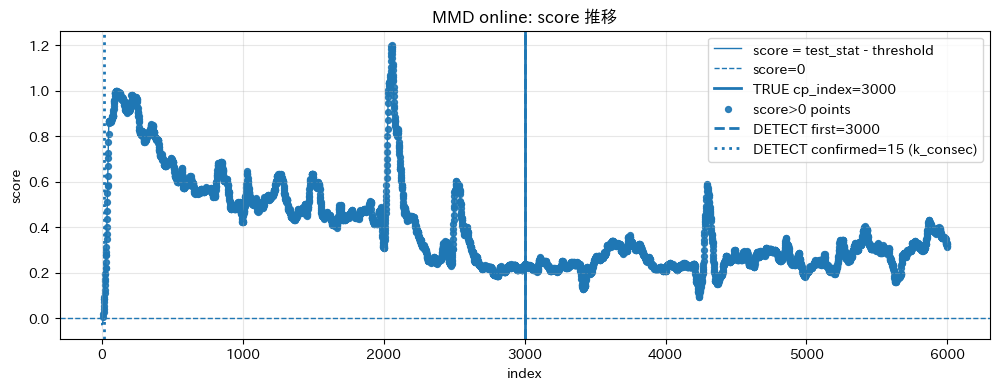

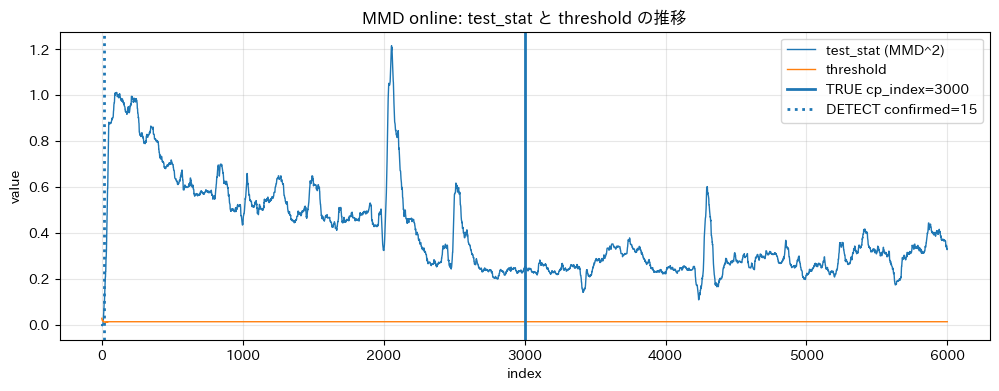

In [33]:

# ============================================================
# 4) 可視化（score / test_stat&threshold）
# ============================================================
n = len(score)
x = np.arange(n)


# score 図
plt.figure(figsize=(12, 4))
plt.plot(score, linewidth=1.0, label="score = test_stat - threshold")
plt.axhline(0.0, linewidth=1.0, linestyle="--", label="score=0")


# 真の変化点
if "cp_index" in globals() and cp_index is not None:
    plt.axvline(int(cp_index), linewidth=2.0, linestyle="-", label=f"TRUE cp_index={int(cp_index)}")

# score>0 の点（全て）
idx_pos = np.where((~np.isnan(score)) & (score > 0))[0]
if len(idx_pos) > 0:
    plt.scatter(idx_pos, score[idx_pos], s=18, alpha=0.9, marker="o", label="score>0 points")

# 検知点（単発）
if i_first_after_cp is not None:
    plt.axvline(i_first_after_cp, linewidth=2.0, linestyle="--", label=f"DETECT first={i_first_after_cp}")

# 検知点（確定）
if i_detect is not None:
    plt.axvline(i_detect, linewidth=2.0, linestyle=":", label=f"DETECT confirmed={i_detect} (k_consec)")

plt.title("MMD online: score 推移")
plt.xlabel("index")
plt.ylabel("score")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# test_stat と threshold 図
plt.figure(figsize=(12, 4))
plt.plot(ts, linewidth=1.0, label="test_stat (MMD^2)")
plt.plot(th, linewidth=1.0, label="threshold")


if "cp_index" in globals() and cp_index is not None:
    plt.axvline(int(cp_index), linewidth=2.0, linestyle="-", label=f"TRUE cp_index={int(cp_index)}")
if i_detect is not None:
    plt.axvline(i_detect, linewidth=2.0, linestyle=":", label=f"DETECT confirmed={i_detect}")

plt.title("MMD online: test_stat と threshold の推移")
plt.xlabel("index")
plt.ylabel("value")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
